### If using colab, mount google drive

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install the required python library (not necessary in colab)

In [2]:
!pip install matplotlib numpy scipy networkx tqdm

### Import the required python libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.spatial import distance
import networkx as nx
import itertools
import math
from scipy.spatial import ConvexHull
from tqdm import tqdm

### Uplaud the G-CODE file. This G-CODE was generated by the software lightburn for laser cutters. Each segments (made from two points) are stored in the list : "sgements"

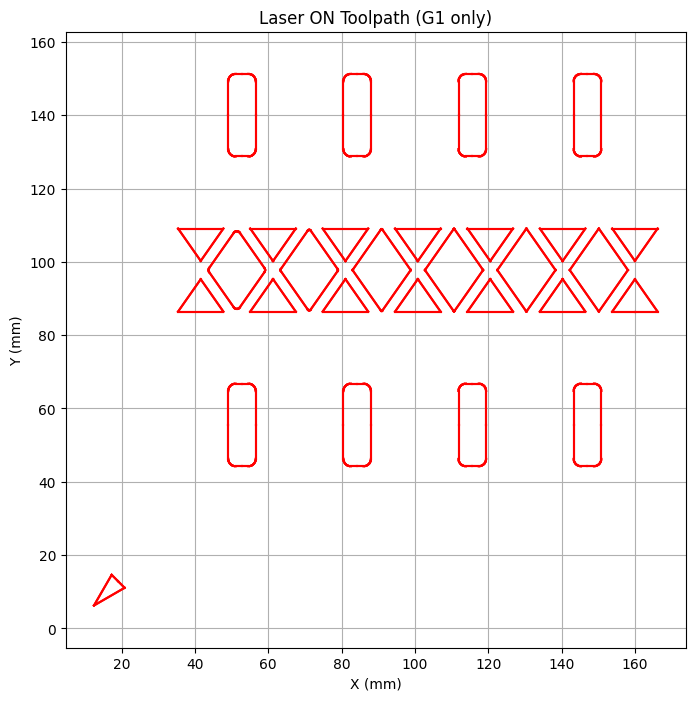

In [4]:
# Path to your G-code file
gcode_path = "/content/drive/My Drive/G-CODE_MODIFICATION/RAW_G-CODE.gc"

# Load G-code
with open(gcode_path, 'r') as file:
    lines = file.readlines()

# Initialize state
x = y = None
x_prev = y_prev = None
segments = []

# Regex pattern to match X and Y values
pattern = re.compile(r'X([-+]?[0-9]*\.?[0-9]+)|Y([-+]?[0-9]*\.?[0-9]+)')

# Process each line
for line in lines:
    line = line.strip()
    if line.startswith(('G0', 'G1')):
        g_command = line.split()[0]  # G0 or G1
        matches = pattern.findall(line)
        for match in matches:
            if match[0]:
                x = float(match[0])
            if match[1]:
                y = float(match[1])

        # # Plot only if laser is ON (G1) and we have previous coordinates
        # if g_command == 'G1' or g_command == 'G0' and None not in (x, y, x_prev, y_prev):
        #     segments.append(((x_prev, x), (y_prev, y)))

        if g_command == 'G1' and None not in (x, y, x_prev, y_prev):
            segments.append(((x_prev, x), (y_prev, y)))

        # Update previous position
        if x is not None and y is not None:
            x_prev, y_prev = x, y

# Plot only G1 segments
plt.figure(figsize=(8, 8))

for x_seg, y_seg in segments:
    plt.plot(x_seg, y_seg, color='red')

plt.title("Laser ON Toolpath (G1 only)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.axis("equal")
plt.grid(True)
plt.show()


### This group of segments forms a series of contour. The idea is to regroup each segments in cluster corresponding to an independant contour.

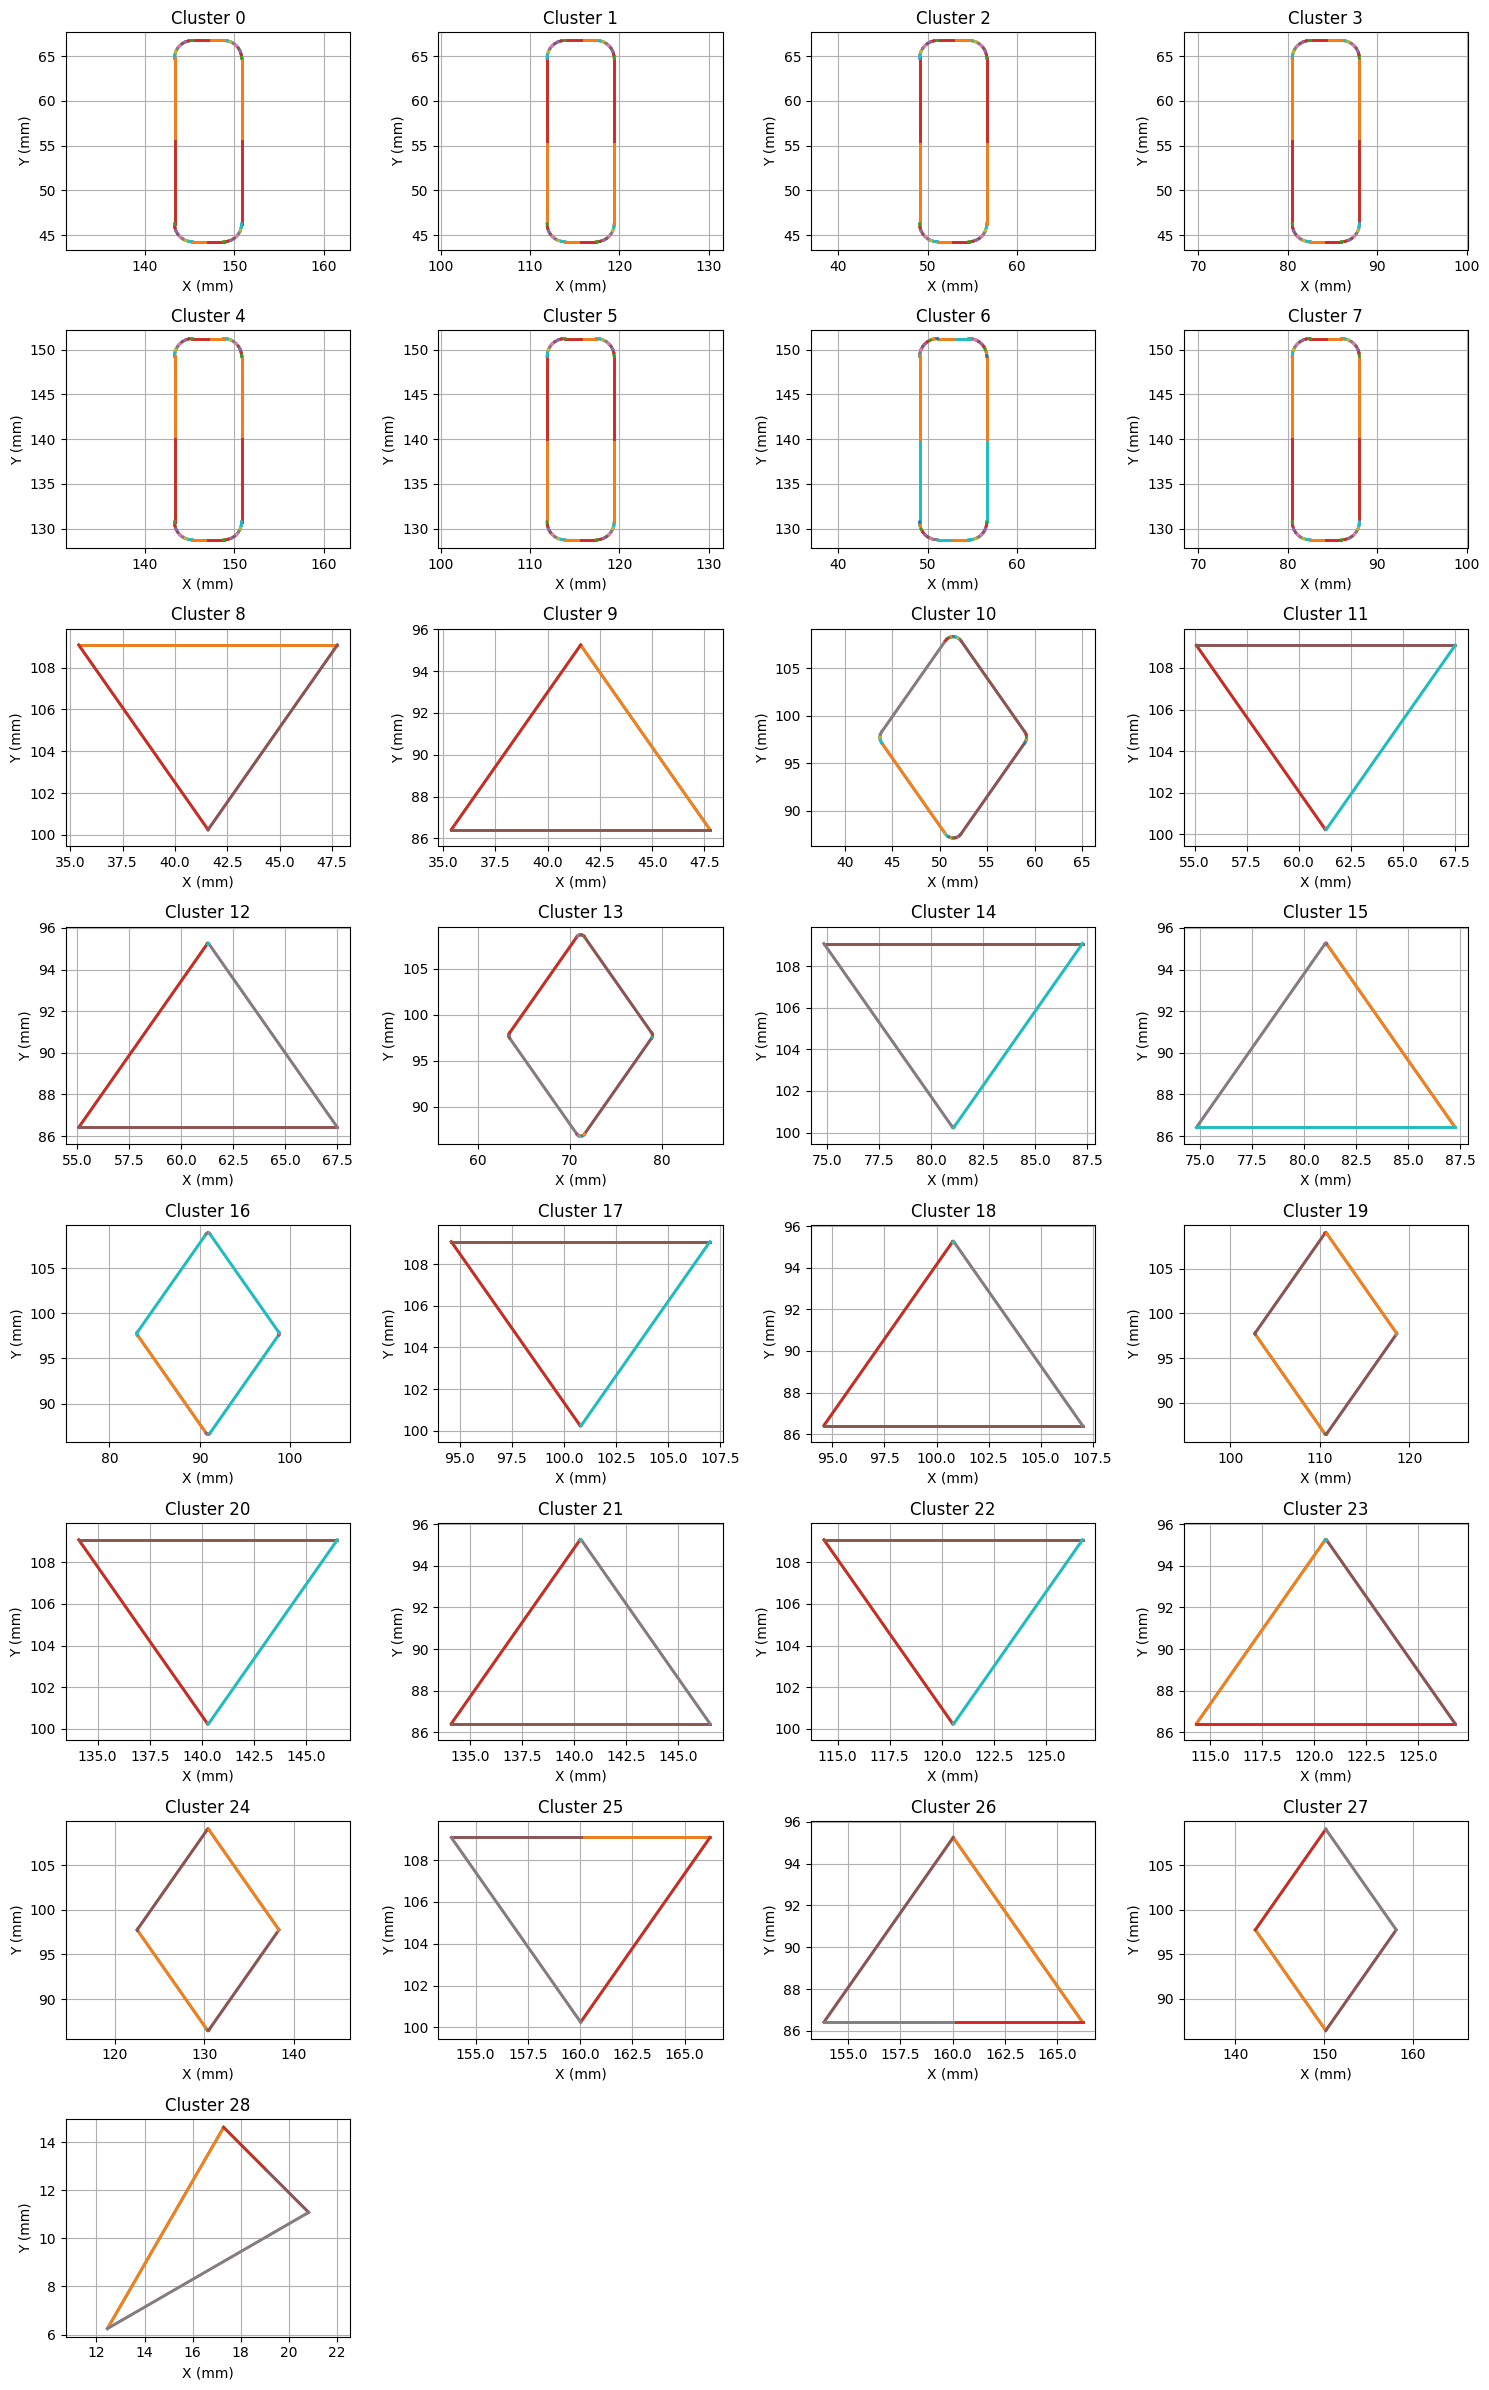

In [5]:
# Distance threshold for "connectedness"
threshold = 1.0

# Convert segments to start/end point pairs
segment_points = [((x[0], y[0]), (x[1], y[1])) for x, y in segments]

# Build graph where segments are connected if endpoints are close
G = nx.Graph()
G.add_nodes_from(range(len(segment_points)))

# Connect segments if endpoints are within the threshold
for i, j in itertools.combinations(range(len(segment_points)), 2):
    p1_start, p1_end = segment_points[i]
    p2_start, p2_end = segment_points[j]
    dists = [
        distance.euclidean(p1_start, p2_start),
        distance.euclidean(p1_start, p2_end),
        distance.euclidean(p1_end, p2_start),
        distance.euclidean(p1_end, p2_end),
    ]
    if min(dists) <= threshold:
        G.add_edge(i, j)

# Extract clusters
clusters = list(nx.connected_components(G))

# Example: clusters is a list of sets
num_clusters = len(clusters)
cols = 4  # You can adjust this
rows = math.ceil(num_clusters / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

# Iterate over the clusters list using enumerate to get both the index (cluster_id) and the cluster set
for cluster_id, segment_indices in enumerate(clusters):
    ax = axes[cluster_id]
    segments2 = []

    for idx in segment_indices:
        x_seg, y_seg = segments[idx]
        ax.plot(x_seg, y_seg, linewidth=2)
        segments2.append((x_seg, y_seg))

    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.axis("equal")
    ax.grid(True)

# Hide any unused subplots
for i in range(num_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### From this cluster of segments, we extract all the points that forms a contour. These point clouds follow an “SVG-like” structure, grouped by arcs, lines, and basic shapes. The goal is to reorder the points so the laser head follows a smooth, continuous path. We do it using a convex hull algorithm. This Cell will in the end produce a list of points array sorted in an ascending order (from the smallest contour to the largest contour)

100%|██████████| 29/29 [00:00<00:00, 36.28it/s]


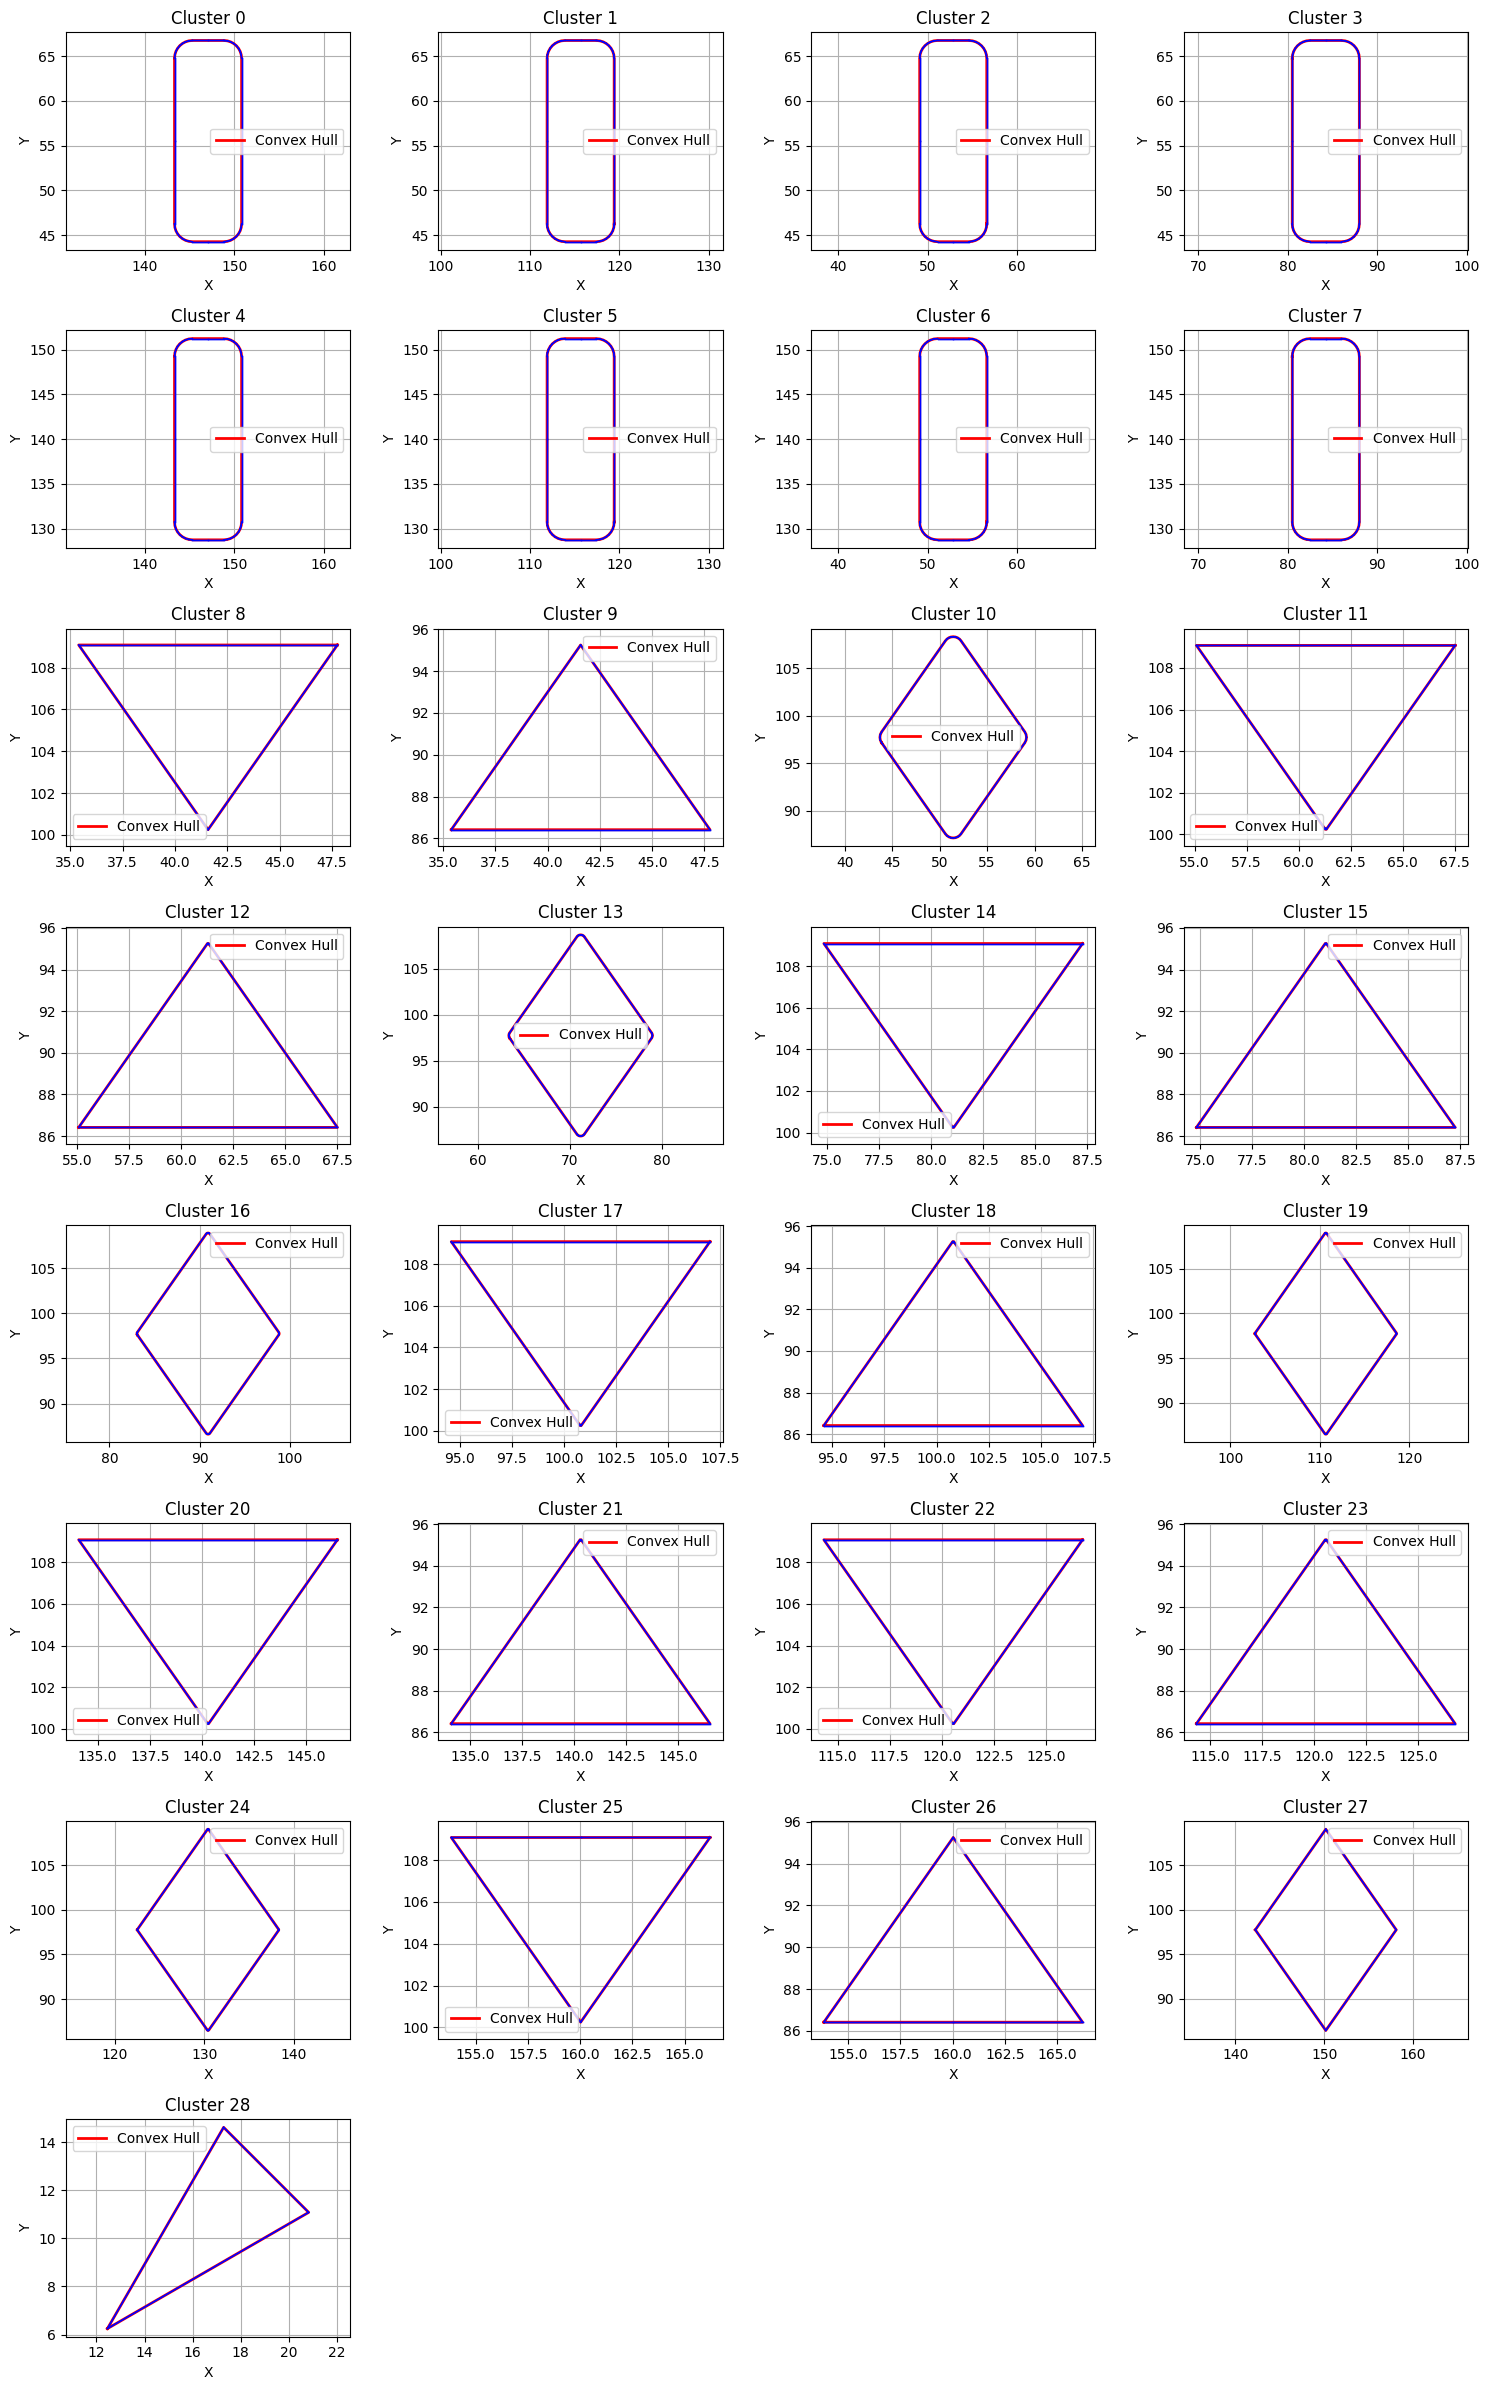

Shape(area=24.32)
Shape(area=33.93)
Shape(area=33.93)
Shape(area=33.93)
Shape(area=33.93)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=34.05)
Shape(area=53.09)
Shape(area=54.21)
Shape(area=54.77)
Shape(area=55.05)
Shape(area=55.11)
Shape(area=55.34)
Shape(area=56.55)
Shape(area=56.55)
Shape(area=56.55)
Shape(area=56.55)
Shape(area=56.55)
Shape(area=56.55)
Shape(area=56.55)
Shape(area=56.55)


In [6]:
class ShapeObject:
    def __init__(self, points: np.ndarray, area: float):
        self.points = points
        self.area = area

    def __repr__(self):
        return f"Shape(area={self.area:.2f})"

shapes = []
num_clusters = len(clusters)
cols = 4
rows = math.ceil(num_clusters / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for cluster_id, segment_indices in enumerate(tqdm(clusters)):
    ax = axes[cluster_id]
    segments2 = [segments[idx] for idx in segment_indices]

    # Flatten into (x, y) points
    points = [(x, y) for (x_seg, y_seg) in segments2 for x, y in zip(x_seg, y_seg)]
    points = np.array(points)

    if len(points) < 3:
        ax.set_title(f"Cluster {cluster_id} (Too few points)")
        continue

    try:
        hull = ConvexHull(points)
        ordered_points = points[hull.vertices]
        closed_loop = np.vstack([ordered_points, ordered_points[0]])  # close loop
        shapes.append(ShapeObject(closed_loop, hull.area))

        # Plot the convex hull
        ax.plot(closed_loop[:, 0], closed_loop[:, 1], color='red', linewidth=2, label="Convex Hull")

        # Plot original segments
        for (x_seg, y_seg) in segments2:
            ax.plot(x_seg, y_seg, color='blue', linewidth=1)

        ax.set_title(f"Cluster {cluster_id}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis("equal")
        ax.grid(True)
        ax.legend()
    except Exception as e:
        ax.set_title(f"Cluster {cluster_id} (Error)")
        print(f"Error in cluster {cluster_id}: {e}")

# Hide any unused subplots
for i in range(num_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Optional: sort and print shapes by area
shapes_sorted = sorted(shapes, key=lambda s: s.area)
for shape in shapes_sorted:
    print(shape)

### Finaly all the contours point from this list are stich together to form a new G-Code. To make sure a shapes is well cut, we can set the number of loops that the laser head will perform.

In [7]:
def generate_gcode_from_shapes(shapes_sorted, feed_rate=2000, power=300, loop_count=2):
    gcode = []

    # Header
    gcode.append("; LightBurn 1.5.06")
    gcode.append("; GRBL device profile, absolute coords")
    gcode.append("; Bounds: X11.63 Y10.38 to X165.38 Y155.38")
    gcode.append("G00 G17 G40 G21 G54")
    gcode.append("G90")
    gcode.append("M4")  # Laser on, dynamic power
    gcode.append(f"; Cut @ {feed_rate} mm/min, {power / 10}% power")
    gcode.append("M8")  # Enable air assist

    for shape_index, shape in enumerate(shapes_sorted):
        pts = shape.points

        if len(pts) < 2:
            continue  # Skip invalid shapes

        for loop in range(loop_count):
            # Move to start point (with laser off)
            x0, y0 = pts[0]
            gcode.append(f"G0 X{x0:.3f}Y{y0:.3f}")
            if loop == 0:
                gcode.append("; Layer C00")

            # First cutting move (laser on)
            x1, y1 = pts[1]
            gcode.append(f"G1 X{x1:.3f}Y{y1:.3f}S{power}F{feed_rate}")

            # Remaining points (laser stays on)
            for x, y in pts[2:]:
                gcode.append(f"G1 X{x:.3f}Y{y:.3f}")

    # Footer
    gcode.append("M9")      # Turn off air assist
    gcode.append("G1 S0")   # Laser power off
    gcode.append("M5")      # Disable spindle/laser
    gcode.append("G90")     # Absolute positioning
    gcode.append("; return to user-defined finish pos")
    gcode.append("G0 X0Y0") # Return to origin
    gcode.append("M2")      # End of program

    return "\n".join(gcode)

We save the new G-CODE in my drive in the end.

In [11]:

gcode_output = generate_gcode_from_shapes(shapes_sorted)
with open("/content/drive/My Drive/G-CODE_MODIFICATION/SMOOTH_G-CODE.gc", "w") as f:
    f.write(gcode_output)

# Optional: preview snippet
print(gcode_output[:1000])  # print first 1000 characters


; LightBurn 1.5.06
; GRBL device profile, absolute coords
; Bounds: X11.63 Y10.38 to X165.38 Y155.38
G00 G17 G40 G21 G54
G90
M4
; Cut @ 2000 mm/min, 30.0% power
M8
G0 X12.458Y6.250
; Layer C00
G1 X20.823Y11.080S300F2000
G1 X17.288Y14.615
G1 X12.458Y6.250
G0 X12.458Y6.250
G1 X20.823Y11.080S300F2000
G1 X17.288Y14.615
G1 X12.458Y6.250
G0 X166.208Y109.082
; Layer C00
G1 X153.839Y109.082S300F2000
G1 X160.024Y100.250
G1 X166.208Y109.082
G0 X166.208Y109.082
G1 X153.839Y109.082S300F2000
G1 X160.024Y100.250
G1 X166.208Y109.082
G0 X153.839Y86.418
; Layer C00
G1 X166.208Y86.418S300F2000
G1 X160.024Y95.250
G1 X153.839Y86.418
G0 X153.839Y86.418
G1 X166.208Y86.418S300F2000
G1 X160.024Y95.250
G1 X153.839Y86.418
G0 X47.764Y109.082
; Layer C00
G1 X35.395Y109.082S300F2000
G1 X41.580Y100.250
G1 X47.764Y109.082
G0 X47.764Y109.082
G1 X35.395Y109.082S300F2000
G1 X41.580Y100.250
G1 X47.764Y109.082
G0 X35.395Y86.418
; Layer C00
G1 X47.764Y86.418S300F2000
G1 X41.580Y95.250
G1 X35.395Y86.418
G0 X35.395Y86.418
G

### Short inspection of the G-code to make sure that it is consistent.

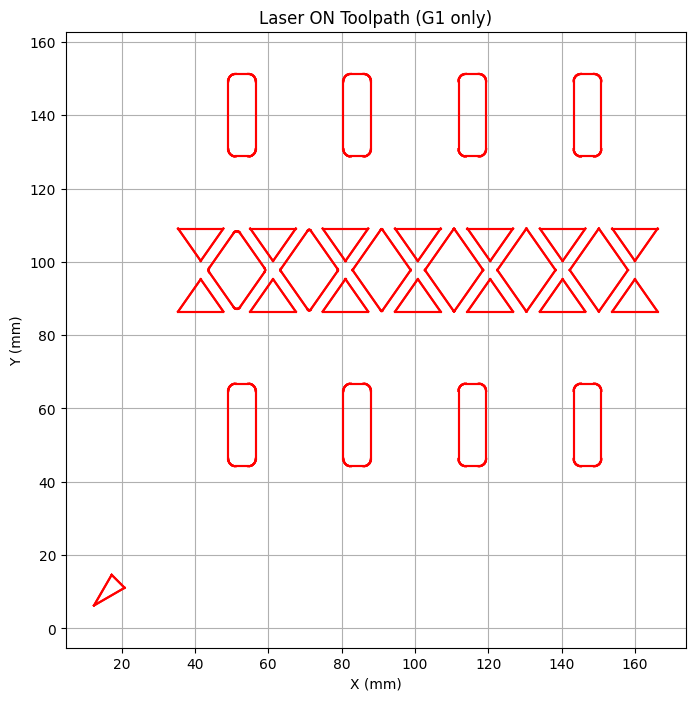

In [12]:
# Path to your G-code file
gcode_path = "/content/drive/My Drive/G-CODE_MODIFICATION/SMOOTH_G-CODE.gc"

# Load G-code
with open(gcode_path, 'r') as file:
    lines = file.readlines()

# Initialize state
x = y = None
x_prev = y_prev = None
segments = []

# Regex pattern to match X and Y values
pattern = re.compile(r'X([-+]?[0-9]*\.?[0-9]+)|Y([-+]?[0-9]*\.?[0-9]+)')

# Process each line
for line in lines:
    line = line.strip()
    if line.startswith(('G0', 'G1')):
        g_command = line.split()[0]  # G0 or G1
        matches = pattern.findall(line)
        for match in matches:
            if match[0]:
                x = float(match[0])
            if match[1]:
                y = float(match[1])

        # # Plot only if laser is ON (G1) and we have previous coordinates
        # if g_command == 'G1' or g_command == 'G0' and None not in (x, y, x_prev, y_prev):
        #     segments.append(((x_prev, x), (y_prev, y)))

        if g_command == 'G1' and None not in (x, y, x_prev, y_prev):
            segments.append(((x_prev, x), (y_prev, y)))

        # Update previous position
        if x is not None and y is not None:
            x_prev, y_prev = x, y

# Plot only G1 segments
plt.figure(figsize=(8, 8))

for x_seg, y_seg in segments:
    plt.plot(x_seg, y_seg, color='red')

plt.title("Laser ON Toolpath (G1 only)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.axis("equal")
plt.grid(True)
plt.show()